### Part 1.4 Label missing values

In [34]:
import pickle as pkl
import numpy as np
import pandas as pd
from functools import reduce
from tensorflow.keras.models import load_model

In [36]:
rgb_channels= True
normalize_image = True
normalize_coordinates = True

In [35]:
dic_train_data=pkl.load(open("data/dic_train_data.pkl","rb"))
dic_missing_data=pkl.load(open("data/dic_missing_data.pkl","rb"))

In [24]:
 # import tensorflow.keras.backend as K
# import tensorflow.keras as keras
# def euclidean_distance_loss(y_true, y_pred):
#   #     Euclidean distance loss
#     return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# def absolute_tanh(x):
#     return K.abs(K.tanh(x))

# load model with custom loss incase want to retrain it otherwise with compile=False
# model = load_model('models/left_eye_center.h5',custom_objects={'euclidean_distance_loss': euclidean_distance_loss})
# model = load_model('models/left_eye_center.h5',compile=False)

In [37]:
features_len = len(dic_train_data)
features_len

14

In [38]:
features = list(dic_train_data.keys())
features

['left_eye_center',
 'right_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'mouth_left_corner',
 'mouth_right_corner',
 'mouth_center_top_lip',
 'mouth_center_bottom_lip']

In [39]:
dic_missing_data["left_eye_center"]

,left_eye_center_x,left_eye_center_y,Image
1687,NaN,NaN,"[[53, 55, 55, 56, 57, 58, 60, 62, 63, 64, 65, ..."
1834,NaN,NaN,"[[68, 68, 69, 68, 68, 70, 67, 68, 73, 70, 70, ..."
1866,NaN,NaN,"[[25, 23, 23, 22, 21, 21, 21, 19, 21, 25, 25, ..."
1938,NaN,NaN,"[[42, 41, 44, 47, 49, 44, 42, 42, 41, 42, 42, ..."
2100,NaN,NaN,"[[35, 16, 26, 31, 56, 33, 18, 25, 39, 71, 96, ..."
2137,NaN,NaN,"[[17, 17, 16, 16, 16, 14, 15, 15, 15, 15, 15, ..."
2153,NaN,NaN,"[[45, 51, 64, 51, 46, 61, 66, 61, 62, 60, 58, ..."
2175,NaN,NaN,"[[0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 4,..."
2186,NaN,NaN,"[[178, 176, 174, 168, 159, 154, 150, 144, 135,..."
2239,NaN,NaN,"[[5, 7, 7, 12, 24, 53, 87, 81, 67, 87, 113, 12..."


In [40]:
import matplotlib.pyplot as plt

def visualize_random_image(df,i=-1):
    """
    Method that visualize a certain image with index i in the df or a random image with i=-1.
    With plotting the facial keypoints specified in the df cols
    """
    # x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
    if i==-1:
        i = np.random.randint(1, len(df))
        plt.figure()
        plt.imshow(df['Image'][i],cmap='gray')
        nbr_cols = df.columns.tolist()[:-1]
        for j in range(0,len(nbr_cols),2):
            plt.plot(df.loc[i][j], df.loc[i][j+1], 'rx')


In [84]:
def pre_process_images(df):
    images = np.vstack(df["Image"].values).reshape(-1, 96, 96, 1).astype(np.float32)
    if rgb_channels:
        images = np.repeat(images,3,-1)
    if normalize_image == True:
        images = images/255
    return images

In [81]:
def predict_images():
    # for each feature we load its trained model and its scalers inorder to get the predicted coordinates for the missing values
    for i in range(0, len(features[:])):
        feature_name = features[i]
        df = dic_missing_data[feature_name]
        images = pre_process_images(df)
        model = load_model('models/'+feature_name+'.h5', compile=False)
        predictions = model.predict(images)#.tolist()
        predictions_x = list(predictions[:,:1].T[0])
        predictions_y = list(predictions[:,1:2].T[0])
        scalers_dict= pkl.load(open("scalers/"+feature_name+"_scalers_dict.pkl","rb"))
        if normalize_coordinates:
            x = [scalers_dict[feature_name+"_x"].inverse_transform([[c_x]]) for c_x in predictions_x]    
            y = [scalers_dict[feature_name+"_y"].inverse_transform([[c_y]]) for c_y in predictions_y]    
        dic_missing_data[feature_name].iloc[:,0] = x
        dic_missing_data[feature_name].iloc[:,1] = y
        

In [85]:
predict_images()

/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying 

In [90]:
# pkl.dump(dic_missing_data, open("data/filled_missing.pkl","wb"))

In [127]:
#  load nose_tip features
nose_tip = pkl.load(open("data/nose_tip.pkl",'rb'))

In [128]:
nose_tip

,index,nose_tip_x,nose_tip_y,Image
0,0,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,1,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,2,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,3,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,4,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."
...,...,...,...,...
7044,7044,48.265961,67.029093,"[[71, 74, 85, 105, 116, 128, 139, 150, 170, 18..."
7045,7045,47.910346,66.626011,"[[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ..."
7046,7046,49.462572,67.515161,"[[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ..."
7047,7047,50.754202,66.724988,"[[254, 254, 254, 254, 254, 238, 193, 145, 121,..."


In [278]:
all_data_dic = dict()
def fill_missing_data(dic_train_data, dic_missing_data):
    for i in range (0, len(features[:])):
        feature_name = features[i]
        d1 = dic_train_data[feature_name]
        d2 = dic_missing_data[feature_name]
        d_new = pd.concat([d1,d2], ignore_index=False)
        d_new.rename(columns={'Image': 'Image_'+feature_name},inplace=True)
        all_data_dic[feature_name] = d_new.reset_index()
        
    return all_data_dic

In [279]:
all_data_dic = fill_missing_data(dic_train_data, dic_missing_data)

In [280]:
all_dataframes= list(all_data_dic.values())

In [281]:
all_dataframes.append(nose_tip)

In [282]:
all_dataframes[4]

,index,right_eye_inner_corner_x,right_eye_inner_corner_y,Image_right_eye_inner_corner
0,0,36.3566,37.3894,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,1,36.0347,34.3615,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,2,37.6781,36.321,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,3,37.6186,38.7541,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,4,36.9824,39.0949,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."
...,...,...,...,...
7044,7044,[[36.19197769478476]],[[36.57521275511641]],"[[71, 74, 85, 105, 116, 128, 139, 150, 170, 18..."
7045,7045,[[36.262770302042966]],[[36.545242301014184]],"[[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ..."
7046,7046,[[36.33934403128321]],[[36.63203550025274]],"[[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ..."
7047,7047,[[35.86783796827643]],[[36.56586540575256]],"[[254, 254, 254, 254, 254, 238, 193, 145, 121,..."


In [283]:
# merge all the features together into main dataframe
main_df = reduce(lambda  left,right: pd.merge(left,right,on=['index'],how='inner'), all_dataframes)

In [284]:
main_df.columns

Index(['index', 'left_eye_center_x', 'left_eye_center_y',
       'Image_left_eye_center', 'right_eye_center_x', 'right_eye_center_y',
       'Image_right_eye_center', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'Image_left_eye_inner_corner',
       'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
       'Image_left_eye_outer_corner', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'Image_right_eye_inner_corner',
       'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
       'Image_right_eye_outer_corner', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'Image_left_eyebrow_inner_end',
       'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
       'Image_left_eyebrow_outer_end', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'Image_right_eyebrow_inner_end',
       'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
       'Image_right_eyebrow_outer_end', 'mouth_left_corner_x',
       'mouth_left_cor

In [293]:
main_df.columns = [*main_df.columns[:-1], 'Image']
main_df = main_df.loc[:, ~main_df.columns.str.startswith('Image_')]
main_df.drop(columns=["index"], inplace=True)

/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [294]:
main_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,nose_tip_x,nose_tip_y,Image
0,66.0336,39.0023,30.227,36.4217,59.5821,39.6474,73.1303,39.97,36.3566,37.3894,...,79.9702,28.6145,77.389,43.3126,72.9355,43.1307,84.4858,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,64.3329,34.9701,29.9493,33.4487,58.8562,35.2743,70.7227,36.1872,36.0347,34.3615,...,76.352,35.1224,76.0477,46.6846,70.2666,45.4679,85.4802,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,65.0571,34.9096,30.9038,34.9096,59.412,36.321,70.9844,36.321,37.6781,36.321,...,73.0143,33.7263,72.732,47.2749,70.1918,47.2749,78.6594,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,65.2257,37.2618,32.0231,37.2618,60.0033,39.1272,72.3147,38.381,37.6186,38.7541,...,72.7037,37.2455,74.1955,50.3032,70.0917,51.5612,78.2684,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,66.7253,39.6213,32.2448,38.042,58.5659,39.6213,72.5159,39.8845,36.9824,39.0949,...,77.5232,31.1918,76.9973,44.9627,73.7074,44.2271,86.8712,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [313]:
def visualize_random_images(df):
    plt.figure(figsize=(30,30))
    for i in range(12):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        j = np.random.randint(1, len(df))
        plt.imshow(df['Image'][j],cmap='gray')
        nbr_cols = df.columns.tolist()[:-1]
        for k in range(0,len(nbr_cols),2):
            plt.plot(df.loc[j][k], df.loc[j][k+1], 'rx')  
    plt.savefig("images/final_examples2.png", bbox_inches = "tight")         
    plt.show()

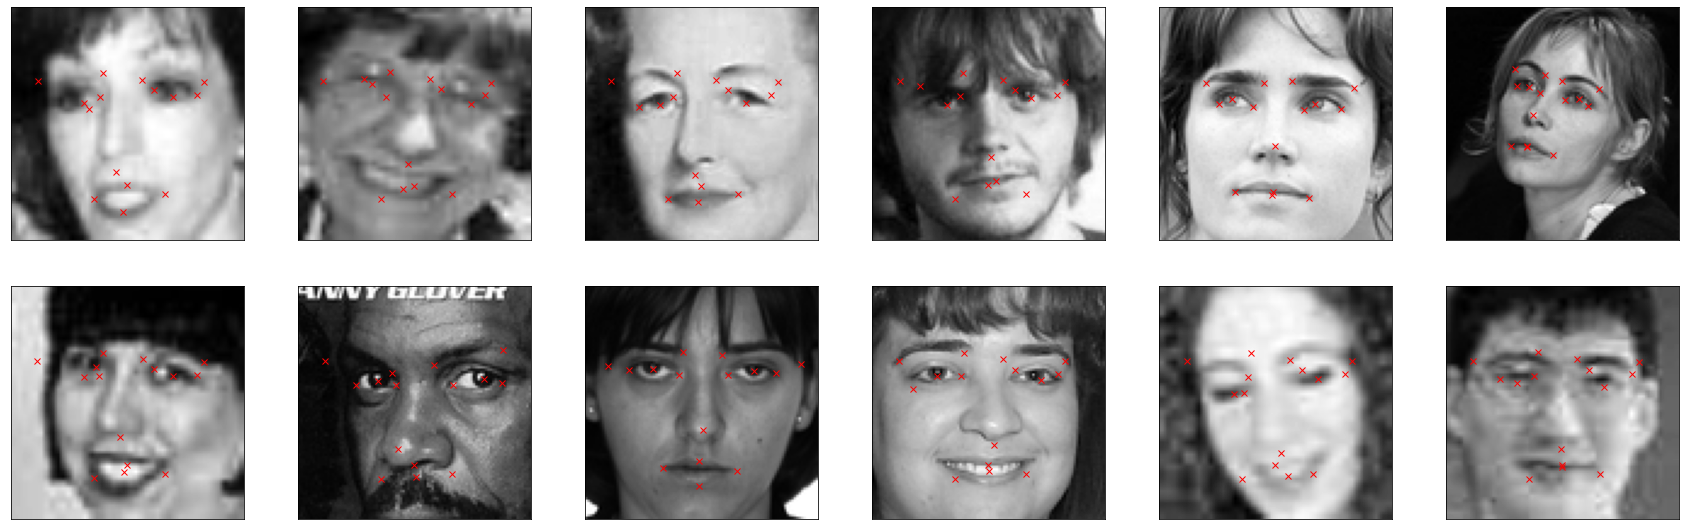

In [311]:
visualize_random_images(main_df)

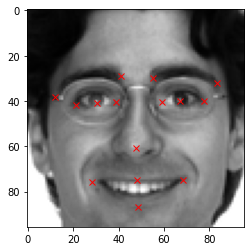

In [207]:
visualize_random_image(main_df)

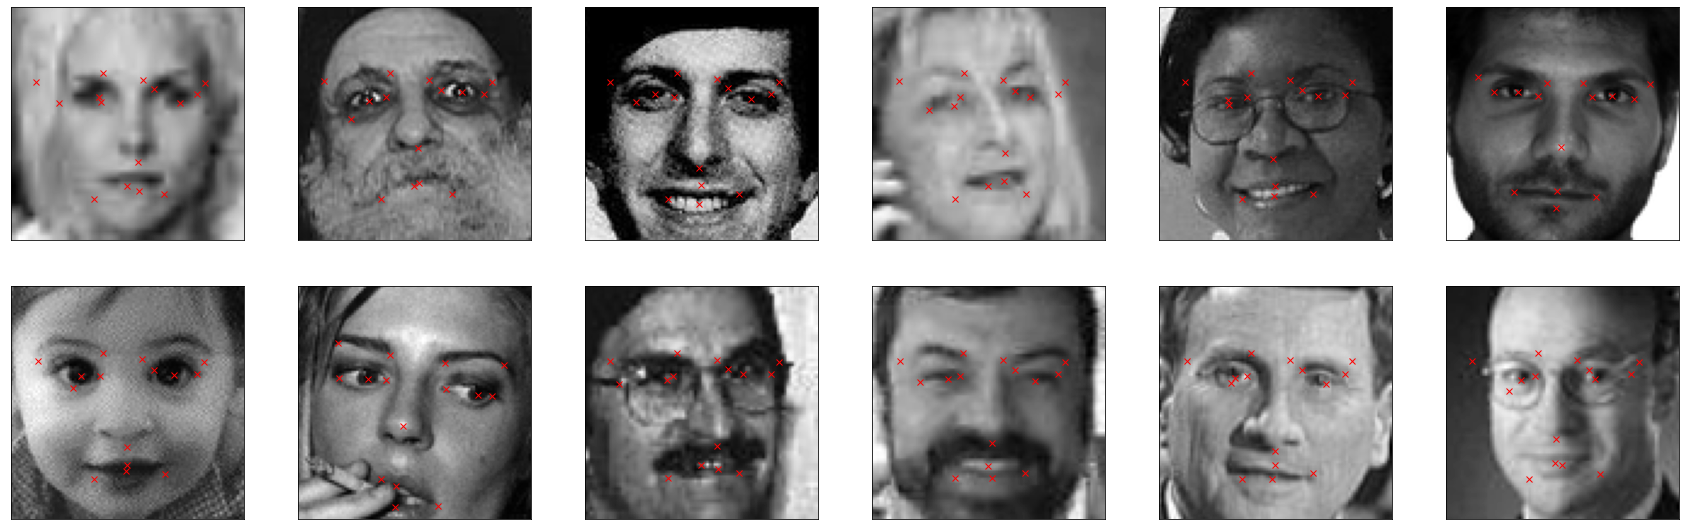

In [314]:
visualize_random_images(main_df)

In [203]:
pkl.dump(main_df, open("data/main_data.pkl","wb"))

In [5]:
main_df = pkl.load(open("data/main_data.pkl","rb"))

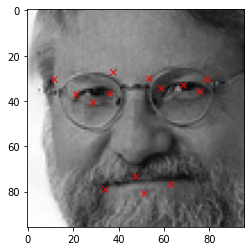

In [30]:
visualize_random_image(main_df)